In [46]:

import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm as tqdm
tf.keras.backend.set_floatx('float32')
from collections import deque
from datetime import datetime
import random
import matplotlib
from environment import Environment
from plots import just_plot, profiles_kennedy
import misc
import nets
from buffer import ReplayBuffer
from datetime import datetime



amplitude=0.4
lr_critic = 0.01
lr_actor = 0.05
ep_guess=1
dolinar_layers=2
number_phases=2
buffer_size = 10**6
tau = 0.1
batch_size=16


env = Environment(amplitude=amplitude, dolinar_layers = dolinar_layers, number_phases=number_phases)
buffer = ReplayBuffer(buffer_size=buffer_size)
critic = nets.Critic(nature="primary", dolinar_layers = dolinar_layers, number_phases=number_phases)
critic_target = nets.Critic(nature="target", dolinar_layers = dolinar_layers, number_phases=number_phases, tau = tau)
actor = nets.Actor(nature="primary", dolinar_layers = dolinar_layers, batch_size_info=batch_size)
actor_target = nets.Actor(nature="target", dolinar_layers = dolinar_layers, tau = tau, batch_size_info=batch_size)

optimizer_critic = tf.keras.optimizers.Adam(lr=lr_critic)
optimizer_actor = tf.keras.optimizers.Adam(lr=lr_actor)



kk = np.load("buffers/2L_pt.npy")
for k in kk:
    buffer.add(tuple(k))
    

lrr = []
context_outcome_actor = np.reshape(np.array([actor.pad_value]*batch_size),(batch_size,1,1)).astype(np.float32)
f=actor(context_outcome_actor)
f=actor_target(context_outcome_actor)


In [47]:
for it in tqdm(range(10**4)):
    sampled_from_buffer = buffer.sample(batch_size).astype(np.float32)
    actor_target.reset_states()
    
    targeted_experience = actor_target.process_sequence_of_experiences_tf(sampled_from_buffer)
    batched_input, zeroed_rews = critic_target.process_sequence_tf(targeted_experience)
    labels_critic = critic_target.give_td_errors_tf( batched_input, zeroed_rews)
    loss_critic = critic.step_critic_tf(batched_input ,labels_critic, optimizer_critic)

    actor.reset_states()
    actored_experiences = actor.process_sequence_of_experiences_tf(sampled_from_buffer)
    dq_da = tf.clip_by_value(critic.critic_grad_tf(actored_experiences), -10e-5, 10e-5) ### To do, check if this does the correct thing for L>1
    actor.actor_grad_tf(dq_da, sampled_from_buffer, optimizer_actor)
    lrr.append(loss_critic)

100%|██████████| 10000/10000 [04:17<00:00, 38.86it/s]


In [48]:
inp = np.random.randn(100,3,2)
betas = np.linspace(-1,1,100)

In [49]:
inp[:,0][:,0] = critic.pad_value
inp[:,0][:,1] = betas


In [50]:
preds = critic(inp)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



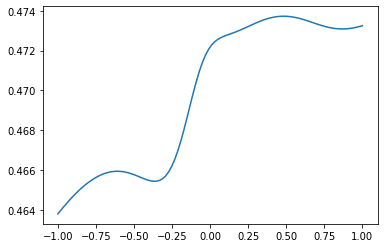

In [51]:
plt.plot(betas,np.squeeze(preds[:,0]))

In [52]:
actor_target(context_outcome_actor)[0]

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.12261603]], dtype=float32)>

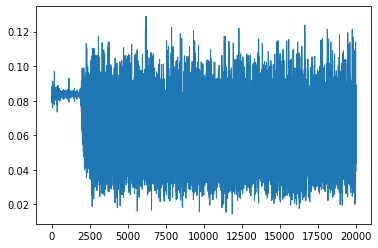

In [14]:
plt.plot(lrr, linewidth=1)

In [ ]:
inp[:,1][:,0] = n1
inp[:,1][:,1] = betas
inp[:,2][:,0] = n2
inp[:,2][:,1] = g